In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from collections import Counter
import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%matplotlib inline

# 数据处理

## 数据加载
	1 = train
	2 = test
	3 = dev


In [3]:
# 加载所有句子
def delete_non_ascii_num(txt):
#     return txt.replace("-LRB-","(").replace("-RRB-",")")
    return ''.join([i if (ord(i) < 128) or (i == '?' or i == '!') else '' for i in txt]).replace("-LRB-","(").replace("-RRB-",")")

sentences  = pd.read_csv("data/stanfordSentimentTreebank/datasetSentences.txt",sep='	')['sentence']
sentiments = pd.read_csv("data/stanfordSentimentTreebank/sentiment_labels.txt",sep='|')['sentiment values']
splits     = pd.read_csv("data/stanfordSentimentTreebank/datasetSplit.txt",sep=',')['splitset_label']
dictionary = pd.read_csv("data/stanfordSentimentTreebank/sentiment_labels.txt",sep='|')['sentiment values']

sentences = sentences.apply(delete_non_ascii_num)
# print(sentences[:5], sentiments[:])


sentiments_level = np.zeros(sentiments.shape).astype(int)
sentiments_level[sentiments <= 0.2] = 0
sentiments_level[(sentiments > 0.2) & (sentiments <= 0.4)] = 1
sentiments_level[(sentiments > 0.4) & (sentiments <= 0.6)] = 2
sentiments_level[(sentiments > 0.6) & (sentiments <= 0.8)] = 3
sentiments_level[(sentiments > 0.8) & (sentiments <= 1.0)] = 4

print(len(sentences),len(sentiments_level), len(splits))
train_sentences, val_sentences, test_sentences = sentences[splits == 1],  sentences[splits == 3],  sentences[splits == 2]
# train_targets,   val_targets,   test_targets   = sentiments[splits == 1], sentiments[splits == 3], sentiments[splits == 2]
sentiments_dic = { str(x): sentiments_level[x] for x in range(0, len(sentiments_level)) }

txtPath = 'data/stanfordSentimentTreebank/dictionary.txt'
diction = {}

 
with open(txtPath,'r', encoding='utf8') as fp:
    for i in fp.readlines():
        u = i.replace("\n","").split("|")
        key = delete_non_ascii_num(u[0])
        diction[key] = sentiments_dic[u[1]]

sentence_sents = []
for sen in sentences:
    sentence_sents.append(diction[sen])

sentiments = pd.Series(sentence_sents)
print(sentiments[:5])

11855 239232 11855
0    3
1    4
2    2
3    3
4    4
dtype: int64


## 描述性统计

## 数据预处理

- 构造词典Vocabulary
- 构造映射表
- 转换单词为tokens

In [4]:
# 句子最大长度
SENTENCE_LIMIT_SIZE = 18
print(len(train_sentences[0].split()))

36


In [5]:
lens = pd.Series([len(x.split()) for x in train_sentences])
print(lens.describe())
print(Counter(lens).most_common())

count    8544.000000
mean       19.143610
std         9.305767
min         2.000000
25%        12.000000
50%        18.000000
75%        25.000000
max        52.000000
dtype: float64
[(15, 353), (19, 351), (18, 342), (16, 334), (14, 334), (17, 327), (20, 325), (13, 319), (22, 317), (21, 312), (12, 308), (11, 305), (10, 298), (23, 296), (24, 290), (9, 265), (25, 259), (26, 238), (6, 231), (8, 228), (28, 226), (27, 223), (7, 218), (29, 171), (31, 158), (30, 157), (5, 154), (4, 152), (32, 151), (33, 124), (34, 123), (35, 99), (3, 96), (36, 69), (38, 61), (37, 54), (41, 40), (2, 40), (39, 38), (40, 31), (42, 24), (43, 24), (44, 20), (45, 18), (46, 11), (48, 8), (49, 8), (51, 4), (50, 4), (52, 3), (47, 3)]


### 构造词典

我们要基于整个语料来构造我们的词典，由于文本中包含许多干扰词汇，例如仅出现过1次的这类单词。对于这类极其低频词汇，我们可以对其进行去除，一方面能加快模型执行效率，一方面也能减少特殊词带来的噪声。

In [6]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from multiprocessing import Pool
import spacy, string
nlp = spacy.load('en')
# 标点符号
punctuations = string.punctuation
print(punctuations)
print(punctuations[1:])
punctuations = punctuations[1:]
# 保留！

def clean_core(doc):
    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and (tok not in punctuations)]
    tokens = ' '.join(tokens)
    tokens = delete_non_ascii_num(tokens)
    return tokens

def cleanup_text(docs, logging=False):
    # 去除停用词
    multiprocess_pool = Pool(64)
    texts = multiprocess_pool.map(clean_core, docs)
    return texts

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
clean_sent = cleanup_text(sentences)
# clean_sent = sentences

total_text = '\n'.join(clean_sent)
# 统计词汇
c = Counter(total_text.split())

In [9]:
# 初始化两个token：pad和unk
vocab = ["<pad>", "<unk>"]

# 去除出现频次过低的单词
for w, f in c.most_common():
    if f > 1:
        vocab.append(w)
print("The total size of our vocabulary is: {}".format(len(vocab)))

The total size of our vocabulary is: 8345


### 构造映射

In [10]:
# 单词到编码的映射，例如machine -> 10283
word_to_token = {word: token for token, word in enumerate(vocab)}
# 编码到单词的映射，例如10283 -> machine
token_to_word = {token: word for word, token in word_to_token.items()}

### 转换文本

In [11]:
def convert_text_to_token(sentence, word_to_token_map=word_to_token, limit_size=SENTENCE_LIMIT_SIZE):
    """
    根据单词-编码映射表将单个句子转化为token
    
    @param sentence: 句子，str类型
    @param word_to_token_map: 单词到编码的映射
    @param limit_size: 句子最大长度。超过该长度的句子进行截断，不足的句子进行pad补全
    
    return: 句子转换为token后的列表
    """
    # 获取unknown单词和pad的token
    unk_id = word_to_token_map["<unk>"]
    pad_id = word_to_token_map["<pad>"]
    
    # 对句子进行token转换，对于未在词典中出现过的词用unk的token填充
    tokens = [word_to_token_map.get(word, unk_id) for word in sentence.split()]
    tokens_size = len(tokens)
    # Pad
    if len(tokens) < limit_size:
        tokens.extend([0] * (limit_size - len(tokens)))
    # Trunc
    else:
        tokens = tokens[:limit_size]
    
    return tokens,tokens_size

In [12]:

# 文本处理->token
tokens = []
total_lens = []

print('converting to token...')
for sentence in tqdm.tqdm(clean_sent):
    tks,tklen = convert_text_to_token(sentence)
    tokens.append(tks)
    total_lens.append(tklen)

total_lens = np.array(total_lens)
total_lens[total_lens > SENTENCE_LIMIT_SIZE] = SENTENCE_LIMIT_SIZE

100%|██████████| 11855/11855 [00:00<00:00, 218855.24it/s]

converting to token...


In [13]:
# 转化为numpy格式，方便处理
total_tokens = np.array(tokens)

## 构造词向量

我们使用glove预训练好的词向量来做embedding:

- 如果当前词没有对应词向量，则用随机数产生的向量替代
- 如果当前词为< PAD >，则用0向量代替

### 加载glove预训练词向量

In [14]:
# 加载预训练好的glove词向量
with open("data/glove.6B.300d.txt", 'r') as f:
    words = set()
    word_to_vec = {}
    for line in f:
        line = line.strip().split()
        # 当前单词
        curr_word = line[0]
        words.add(curr_word)
        # 当前词向量
        word_to_vec[curr_word] = np.array(line[1:], dtype=np.float32)
print("The number of words which have pretrained-vectors in vocab is: {}".format(len(set(vocab)&set(words))))
print()
print("The number of words which do not have pretrained-vectors in vocab is : {}".format(len(set(vocab))-
                                                                                         len(set(vocab)&set(words))))

The number of words which have pretrained-vectors in vocab is: 8244

The number of words which do not have pretrained-vectors in vocab is : 101


In [21]:
set(vocab) - set(vocab)&set(words)

set()

In [23]:
# set([1, 2, 3]) - set([1, 2, 3])

set()

### 构造词向量矩阵

In [24]:
VOCAB_SIZE = len(vocab)  # 9801
EMBEDDING_SIZE = 300

# 初始化词向量矩阵（这里命名为static是因为这个词向量矩阵用预训练好的填充，无需重新训练）
static_embeddings = np.zeros([VOCAB_SIZE, EMBEDDING_SIZE])

for word, token in tqdm.tqdm(word_to_token.items()):
    # 用glove词向量填充，如果没有对应的词向量，则用随机数填充
    word_vector = word_to_vec.get(word, 0.2 * np.random.random(EMBEDDING_SIZE) - 0.1)
    static_embeddings[token, :] = word_vector

# 重置PAD为0向量
pad_id = word_to_token["<pad>"]
static_embeddings[pad_id, :] = np.zeros(EMBEDDING_SIZE)
static_embeddings = static_embeddings.astype(np.float32)

100%|██████████| 8345/8345 [00:00<00:00, 66097.37it/s]


## 辅助函数

### 分割train和test

In [25]:
clean_sent = pd.Series(clean_sent)
# mask
m_train, m_val, m_test = splits==1, splits == 3, splits == 2


x_train, x_train_len = total_tokens[m_train], total_lens[m_train]
x_val  , x_val_len   = total_tokens[m_val],   total_lens[m_val]
x_test , x_test_len  = total_tokens[m_test],  total_lens[m_test]
y_train, y_val, y_test = sentiments[m_train].values, sentiments[m_val].values, sentiments[m_test].values

# onehot
def onehot_encode(label):
    value_set = set(label.tolist())
    dimension = len(value_set)
    mat = np.zeros((label.shape[0], dimension))
    for index, i in enumerate(label):
        mat[index][i] = 1
    return mat

# y_train = onehot_encode(y_train)
# y_val = onehot_encode(y_val)
# y_test = onehot_encode(y_test)

# y_train = y_train[:, np.newaxis] -1 
# y_val = y_val[:, np.newaxis] - 1
# y_test = y_test[:, np.newaxis] -1 
# y_train, y_val, y_test = y_train - 1, y_val - 1, y_test - 1

8544 2210 1101


/home/mingyu_zhang/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/home/mingyu_zhang/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/home/mingyu_zhang/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


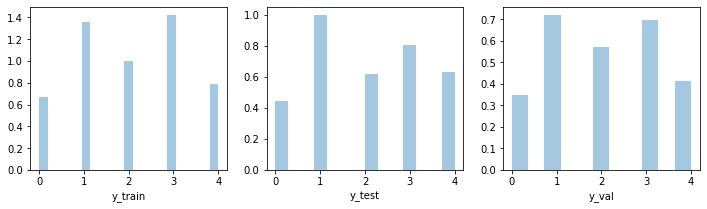

In [34]:
# plt.legend(loc='upper left')
import seaborn as sns
print(len(y_train), len(y_test), len(y_val) )
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
sns.distplot(pd.Series(y_train, name="y_train"), kde=False, norm_hist=True)
plt.subplot(1,3,2)
sns.distplot(pd.Series(y_test, name="y_test"), kde=False, norm_hist=True)
plt.subplot(1,3,3)
sns.distplot(pd.Series(y_val, name="y_val"), kde=False, norm_hist=True)
plt.show()

## 混淆矩阵

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def draw_confusion_matrix(y_true, y_pred):
    labels = list(set(y_true))
    conf_mat = confusion_matrix(y_true, y_pred, labels = labels) / len(y_true)
    sns.heatmap(conf_mat,annot=True,cmap="Blues")

def get_batch(x, y, batch_size=256, shuffle=False):
    assert x.shape[0] == y.shape[0], print("error shape!")
    # shuffle
    if shuffle:
        shuffled_index = np.random.permutation(range(x.shape[0]))        
        x = x[shuffled_index]
        y = y[shuffled_index]
    
    # 统计共几个完整的batch
    n_batches = int(x.shape[0] / batch_size)
    
    for i in range(n_batches - 1):
        x_batch = x[i*batch_size: (i+1)*batch_size]
        y_batch = y[i*batch_size: (i+1)*batch_size]
    
        yield x_batch, y_batch

def get_batch_lens(x, y, lens, batch_size=256, shuffle=True):
    assert x.shape[0] == y.shape[0], print("error shape!")
    # shuffle
    if shuffle:
        shuffled_index = np.random.permutation(range(x.shape[0]))

        x = x[shuffled_index]
        y = y[shuffled_index]
        l = lens[shuffled_index]
    
    # 统计共几个完整的batch
    n_batches = int(x.shape[0] / batch_size)
    
    for i in range(n_batches - 1):
        x_batch = x[i*batch_size: (i+1)*batch_size]
        y_batch = y[i*batch_size: (i+1)*batch_size]
        l_batch = lens[i*batch_size: (i+1)*batch_size]

    
        yield x_batch, y_batch, l_batch

# DNN模型

## 构建模型图

In [47]:
# 清空图
tf.reset_default_graph()

# 定义神经网络超参数
HIDDEN_SIZE   = 16
LEARNING_RATE = 1e-3
tf.set_random_seed(1234)

with tf.name_scope("dnn"):
    # 输入及输出tensor
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, SENTENCE_LIMIT_SIZE), name="inputs")
        targets = tf.placeholder(dtype=tf.int32, shape=(None,), name="targets")
        prob = tf.placeholder_with_default(1.0, shape=())
        training = tf.placeholder_with_default(False, shape=())

    
    # embeddings
    with tf.name_scope("embeddings"):
        # 用pre-trained词向量来作为embedding层
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
        
        # 相加词向量得到句子向量
        sum_embed = tf.reduce_sum(embed, axis=1, name="sum_embed")
        
    # model
    with tf.name_scope("model"):

        dense1 = tf.layers.dense(sum_embed, 
                                 units=HIDDEN_SIZE, 
                                 use_bias=True,
                                 activation=tf.nn.relu)
        
#         dense2 = tf.layers.dense(dense1, 
#                          units=HIDDEN_SIZE, 
#                          use_bias=True,
#                          activation=tf.nn.relu)
        
        outputs = tf.layers.dense(dense1, 
                         units=5, 
                         use_bias=True,
                         activation=None)
        
        
#         outputs = tf.nn.sigmoid(dense3, name="outputs")
    
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=outputs))
    
    # optimizer
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
        
    # evaluation
    with tf.name_scope("evaluation"):
        preds = tf.cast(tf.argmax(tf.nn.sigmoid(outputs), axis=1), tf.int32)
        correct_preds = tf.equal(preds, targets)
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

## 训练DNN模型

In [48]:
EPOCHES       = 100
BATCH_SIZE    = 128
# 存储准确率
nn_train_accuracy = []
nn_val_accuracy = []
saver = tf.train.Saver()

np.random.seed(0)

best_val_accuracy = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/dnn", tf.get_default_graph())
    
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        train_correct = 0
        # 计算epoch损失
        for x_batch, y_batch in get_batch(x_train, y_train, BATCH_SIZE, True):
            _, batch_loss,correct = sess.run([optimizer, loss, accuracy],
                                     feed_dict={inputs: x_batch, 
                                                targets: y_batch, 
                                                prob: 0.5,
                                                training: True})
            train_correct += correct
            total_loss    += batch_loss
            
        # 在train上准确率
#         train_correct = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_correct / x_train.shape[0]
        nn_train_accuracy.append(train_acc)
        
        # 在val上准确率
        val_corrects = sess.run(accuracy, feed_dict={inputs: x_val, targets: y_val})
        val_acc = val_corrects / x_val.shape[0]
        nn_val_accuracy.append(val_acc)
        
        if best_val_accuracy < val_acc:
            saver.save(sess, "./checkpoints/dnn_best")
            writer.close()
            best_val_accuracy = val_acc

            
        if (epoch + 1) % 10 == 0:
            print("Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Val accuracy: {:.4f}".format(epoch + 1, 
                                                                                                    total_loss/n_batches,
                                                                                                    train_acc,
                                                                                                    val_acc))

Epoch: 10, Train loss: 1.2512, Train accuracy: 0.4479, Val accuracy: 0.3969
Epoch: 20, Train loss: 1.1545, Train accuracy: 0.4954, Val accuracy: 0.3833
Epoch: 30, Train loss: 1.0954, Train accuracy: 0.5172, Val accuracy: 0.3751
Epoch: 40, Train loss: 1.0492, Train accuracy: 0.5358, Val accuracy: 0.3715
Epoch: 50, Train loss: 1.0126, Train accuracy: 0.5526, Val accuracy: 0.3769
Epoch: 60, Train loss: 0.9832, Train accuracy: 0.5681, Val accuracy: 0.3715
Epoch: 70, Train loss: 0.9650, Train accuracy: 0.5741, Val accuracy: 0.3588
Epoch: 80, Train loss: 0.9431, Train accuracy: 0.5820, Val accuracy: 0.3624
Epoch: 90, Train loss: 0.9268, Train accuracy: 0.5838, Val accuracy: 0.3579
Epoch: 100, Train loss: 0.9128, Train accuracy: 0.5935, Val accuracy: 0.3715


[best] epoch: 9, val-accuracy 0.3969
INFO:tensorflow:Restoring parameters from checkpoints/dnn_best
The dnn model accuracy on test set: 0.4072


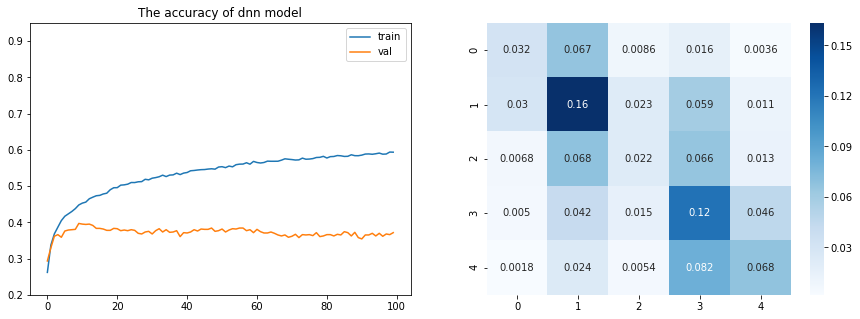

In [49]:
model_type = 'dnn'
best_epoch = np.argmax(nn_val_accuracy)
print("[best] epoch: {}, val-accuracy {:.4f}".format(best_epoch, nn_val_accuracy[best_epoch]))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nn_train_accuracy)
plt.plot(nn_val_accuracy)
plt.ylim(ymin=0.2, ymax=0.95)
plt.title("The accuracy of {} model".format(model_type))
plt.legend(["train", "val"])

plt.subplot(1,2,2)
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/{}_best".format(model_type))
    acc_v,preds_v = sess.run([accuracy, preds],
                    feed_dict={ inputs: x_test, 
                                targets: y_test})
    draw_confusion_matrix(y_test.squeeze().tolist(), preds_v.squeeze().tolist())
    print("The {} model accuracy on test set: {:.4f}".format(model_type, acc_v / x_test.shape[0]))
plt.savefig('dnn_test2.png',dpi=400,pad_inches=0.0,bbox_inches='tight')

# RNN模型

## 构建模型图

In [66]:
# 清空图
tf.reset_default_graph()

# 定义网络超参数
HIDDEN_SIZE = 8
LEARNING_RATE = 1e-3

tf.set_random_seed(1234)

with tf.name_scope("rnn"):
    # placeholders
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, SENTENCE_LIMIT_SIZE), name="inputs")
        targets = tf.placeholder(dtype=tf.int32, shape=(None,), name="targets")
        input_lens = tf.placeholder(dtype=tf.int32, shape=(None, ), name="inputs_lens")
        prob = tf.placeholder_with_default(1.0, shape=())
    
    # embeddings
    with tf.name_scope("embeddings"):
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
    
    # model
    with tf.name_scope("model"):
        # 构造lstm单元
        lstm = tf.contrib.rnn.LSTMCell(HIDDEN_SIZE, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=123))
        # 添加dropout
        drop_lstm = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=prob, seed=2)
        _, lstm_state = tf.nn.dynamic_rnn(drop_lstm, embed, dtype=tf.float32, sequence_length=input_lens)
        
        outputs = tf.layers.dense(lstm_state.h, 
                         units=5, 
                         use_bias=True,
                         activation=None)
        
    # evaluation
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=outputs))
    
    # optimizer
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
        
    # evaluation
    with tf.name_scope("evaluation"):
        preds = tf.cast(tf.argmax(tf.nn.sigmoid(outputs), axis=1), tf.int32)
        correct_preds = tf.equal(preds, targets)
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

## 训练模型

In [68]:
EPOCHES = 100
BATCH_SIZE = 128
# 存储准确率
nn_train_accuracy = []
nn_val_accuracy = []
saver = tf.train.Saver()

best_val_accuracy = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/rnn", tf.get_default_graph())
    
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        train_correct = 0
        # 计算epoch损失
        for x_batch, y_batch, l_batch in get_batch_lens(x_train, y_train, x_train_len, BATCH_SIZE, True):
            _, batch_loss,correct = sess.run([optimizer, loss, accuracy],
                                     feed_dict={inputs: x_batch, 
                                                targets: y_batch, 
                                                input_lens: l_batch,
                                                prob: 0.5})
            train_correct += correct
            total_loss    += batch_loss
            
        # 在train上准确率
#         train_correct = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_correct / x_train.shape[0]
        nn_train_accuracy.append(train_acc)
        
        # 在val上准确率
        val_corrects = sess.run(accuracy, feed_dict={inputs: x_val, targets: y_val, input_lens: x_val_len})
        val_acc = val_corrects / x_val.shape[0]
        nn_val_accuracy.append(val_acc)
        
        if best_val_accuracy < val_acc:
            saver.save(sess, "./checkpoints/rnn_best")
            writer.close()
            best_val_accuracy = val_acc

            
        if (epoch + 1) % 10 == 0:
            print("Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Val accuracy: {:.4f}".format(epoch + 1, 
                                                                                                    total_loss/n_batches,
                                                                                                    train_acc,
                                                                                                    val_acc))

Epoch: 10, Train loss: 1.2941, Train accuracy: 0.4161, Val accuracy: 0.3996
Epoch: 20, Train loss: 1.2170, Train accuracy: 0.4666, Val accuracy: 0.4114
Epoch: 30, Train loss: 1.1488, Train accuracy: 0.5027, Val accuracy: 0.4060
Epoch: 40, Train loss: 1.1113, Train accuracy: 0.5254, Val accuracy: 0.4015
Epoch: 50, Train loss: 1.0637, Train accuracy: 0.5508, Val accuracy: 0.3878
Epoch: 60, Train loss: 1.0255, Train accuracy: 0.5727, Val accuracy: 0.3787
Epoch: 70, Train loss: 1.0027, Train accuracy: 0.5775, Val accuracy: 0.3706
Epoch: 80, Train loss: 0.9810, Train accuracy: 0.5921, Val accuracy: 0.3742
Epoch: 90, Train loss: 0.9645, Train accuracy: 0.6008, Val accuracy: 0.3733
Epoch: 100, Train loss: 0.9471, Train accuracy: 0.6080, Val accuracy: 0.3669


[best] epoch: 14, val-accuracy 0.4260
INFO:tensorflow:Restoring parameters from checkpoints/rnn_best
The rnn model accuracy on test set: 0.4041


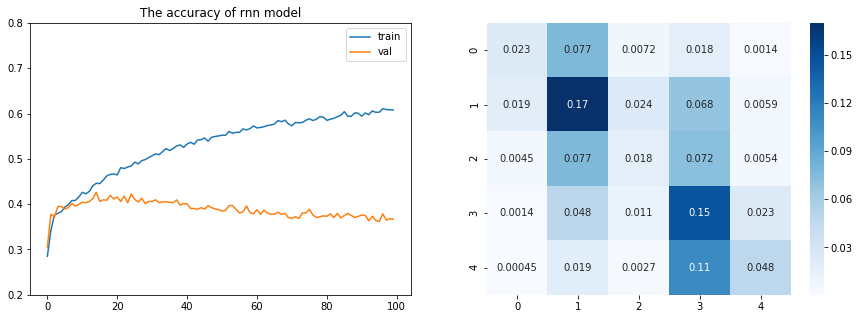

In [69]:
# 4114, 4308
model_type = 'rnn'
best_epoch = np.argmax(nn_val_accuracy)
print("[best] epoch: {}, val-accuracy {:.4f}".format(best_epoch, nn_val_accuracy[best_epoch]))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nn_train_accuracy)
plt.plot(nn_val_accuracy)
plt.ylim(ymin=0.2, ymax=0.8)
plt.title("The accuracy of {} model".format(model_type))
plt.legend(["train", "val"])

plt.subplot(1,2,2)
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/{}_best".format(model_type))
    acc_v,preds_v = sess.run([accuracy, preds],
                    feed_dict={ inputs: x_test, 
                                targets: y_test,
                                 input_lens: x_test_len})
    draw_confusion_matrix(y_test.squeeze().tolist(), preds_v.squeeze().tolist())
    print("The {} model accuracy on test set: {:.4f}".format(model_type, acc_v / x_test.shape[0]))

plt.savefig('rnn_test2.png',dpi=400,pad_inches=0.0,bbox_inches='tight')

# CNN模型

## 构建模型图

In [76]:
# 清空图
tf.reset_default_graph()

# 我在这里定义了5种filter，每种100个
filters_size  = [3, 4, 5]
num_filters   = 100
# 超参数
LEARNING_RATE = 1e-4
L2_LAMBDA     = 3

tf.set_random_seed(1234)
with tf.name_scope("cnn"):
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, SENTENCE_LIMIT_SIZE), name="inputs")
        targets = tf.placeholder(dtype=tf.int32, shape=(None,), name="targets")
        prob = tf.placeholder_with_default(1.0, shape=())
    
    # embeddings
    with tf.name_scope("embeddings"):
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
        # 添加channel维度
        embed_expanded = tf.expand_dims(embed, -1, name="embed_expand")
    
    # 用来存储max-pooling的结果
    pooled_outputs = []

    # 迭代多个filter
    for i, filter_size in enumerate(filters_size):
        with tf.name_scope("conv_maxpool_%s" % filter_size):
            filter_shape = [filter_size, EMBEDDING_SIZE, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, mean=0.0, stddev=0.1), name="W")
            b = tf.Variable(tf.zeros(num_filters), name="b")

            conv = tf.nn.conv2d(input=embed_expanded, 
                                 filter=W, 
                                 strides=[1, 1, 1, 1], 
                                 padding="VALID",
                                 name="conv")

            # 激活
            a = tf.nn.relu(tf.nn.bias_add(conv, b), name="activations")
            
            # 池化
            max_pooling = tf.nn.max_pool(value=a, 
                                    ksize=[1, SENTENCE_LIMIT_SIZE - filter_size + 1, 1, 1],
                                    strides=[1, 1, 1, 1],
                                    padding="VALID",
                                    name="max_pooling")
            
            pooled_outputs.append(max_pooling)
    
    # 统计所有的filter
    total_filters = num_filters * len(filters_size)
    total_pool = tf.concat(pooled_outputs, 3)
    flattend_pool = tf.reshape(total_pool, (-1, total_filters))
    
    # dropout
    with tf.name_scope("dropout"):
        dropout = tf.nn.dropout(flattend_pool, prob, seed=2)
    
    # output
    with tf.name_scope("output"):
        logits = tf.layers.dense(dropout, 
                                 units=5, 
                                 use_bias=True,
                                 activation=None)
    
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
        loss = loss + L2_LAMBDA * tf.nn.l2_loss(W)
        
    # optimizer
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
        
    # evaluation    
    with tf.name_scope("evaluation"):
        preds = tf.cast(tf.argmax(logits, axis=1), tf.int32)
        correct_preds = tf.equal(preds, targets)
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

## 训练模型

In [ ]:
EPOCHES       = 100
BATCH_SIZE    = 128
# 存储准确率
nn_train_accuracy = []
nn_val_accuracy = []
saver = tf.train.Saver()

np.random.seed(0)

best_val_accuracy = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/cnn", tf.get_default_graph())
    
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        train_correct = 0
        # 计算epoch损失
        for x_batch, y_batch in get_batch(x_train, y_train, BATCH_SIZE, False):
            _, batch_loss,correct = sess.run([optimizer, loss, accuracy],
                                     feed_dict={inputs: x_batch, targets: y_batch, prob: 0.5})
            train_correct += correct
            total_loss    += batch_loss
            
        # 在train上准确率
#         train_correct = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_correct / x_train.shape[0]
        nn_train_accuracy.append(train_acc)
        
        # 在val上准确率
        val_corrects = sess.run(accuracy, feed_dict={inputs: x_val, targets: y_val})
        val_acc = val_corrects / x_val.shape[0]
        nn_val_accuracy.append(val_acc)
        
        if best_val_accuracy < val_acc:
            saver.save(sess, "./checkpoints/cnn_best")
            writer.close()
            best_val_accuracy = val_acc

            
        if (epoch + 1) % 10 == 0:
            print("Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Val accuracy: {:.4f}".format(epoch + 1, 
                                                                                                    total_loss/n_batches,
                                                                                                    train_acc,
                                                                                                    val_acc))

Epoch: 10, Train loss: 540.9148, Train accuracy: 0.2595, Val accuracy: 0.3197
Epoch: 20, Train loss: 144.6673, Train accuracy: 0.3392, Val accuracy: 0.3497
Epoch: 30, Train loss: 31.8831, Train accuracy: 0.4038, Val accuracy: 0.3669
Epoch: 40, Train loss: 5.8434, Train accuracy: 0.4505, Val accuracy: 0.3715
Epoch: 50, Train loss: 1.5809, Train accuracy: 0.4971, Val accuracy: 0.3815
Epoch: 60, Train loss: 1.1260, Train accuracy: 0.5371, Val accuracy: 0.3833
Epoch: 70, Train loss: 1.0403, Train accuracy: 0.5757, Val accuracy: 0.3869
Epoch: 80, Train loss: 0.9851, Train accuracy: 0.5962, Val accuracy: 0.3851
Epoch: 90, Train loss: 0.9111, Train accuracy: 0.6354, Val accuracy: 0.3842


[best] epoch: 69, val-accuracy 0.3887
INFO:tensorflow:Restoring parameters from checkpoints/cnn_best
The cnn model accuracy on test set: 0.3932


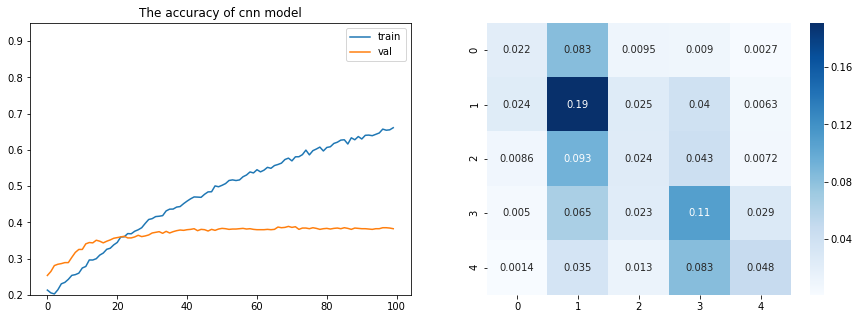

In [75]:
model_type = 'cnn'
best_epoch = np.argmax(nn_val_accuracy)
print("[best] epoch: {}, val-accuracy {:.4f}".format(best_epoch, nn_val_accuracy[best_epoch]))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nn_train_accuracy)
plt.plot(nn_val_accuracy)
plt.ylim(ymin=0.2, ymax=0.95)
plt.title("The accuracy of {} model".format(model_type))
plt.legend(["train", "val"])

plt.subplot(1,2,2)
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/{}_best".format(model_type))
    acc_v,preds_v = sess.run([accuracy, preds],
                    feed_dict={ inputs: x_test, 
                                targets: y_test})
    draw_confusion_matrix(y_test.squeeze().tolist(), preds_v.squeeze().tolist())
    print("The {} model accuracy on test set: {:.4f}".format(model_type, acc_v / x_test.shape[0]))
    
plt.savefig('cnn_test2.png',dpi=400,pad_inches=0.0,bbox_inches='tight')

In [247]:
# MYNET
# 清空图
tf.reset_default_graph()

# 我在这里定义了5种filter，每种100个
filters_size = [3,4,5]
num_filters = 100
# 超参数
LEARNING_RATE = 1e-3
L2_LAMBDA     = 20

with tf.name_scope("cnn"):
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, SENTENCE_LIMIT_SIZE), name="inputs")
        targets = tf.placeholder(dtype=tf.int32, shape=(None,), name="targets")
        prob = tf.placeholder_with_default(1.0, shape=())
    
    # embeddings
    with tf.name_scope("embeddings"):
        embedding_matrix = tf.Variable(initial_value=static_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
        # 添加channel维度
        embed_expanded = tf.expand_dims(embed, -1, name="embed_expand")
    
    # 用来存储max-pooling的结果
    pooled_outputs = []

    # 迭代多个filter
    for i, filter_size in enumerate(filters_size):
        with tf.name_scope("conv_maxpool_%s" % filter_size):
            filter_shape = [filter_size, EMBEDDING_SIZE, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, mean=0.0, stddev=0.1), name="W")
            b = tf.Variable(tf.zeros(num_filters), name="b")

            conv = tf.nn.conv2d(input=embed_expanded, 
                                 filter=W, 
                                 strides=[1, 1, 1, 1], 
                                 padding="VALID",
                                 name="conv")

            # 激活
            a = tf.nn.relu(tf.nn.bias_add(conv, b), name="activations")
            # 池化
            max_pooling = tf.nn.max_pool(value=a, 
                                    ksize=[1, SENTENCE_LIMIT_SIZE - filter_size + 1, 1, 1],
                                    strides=[1, 1, 1, 1],
                                    padding="VALID",
                                    name="max_pooling")
            pooled_outputs.append(max_pooling)
    
    # 统计所有的filter
    total_filters = num_filters * len(filters_size)
    total_pool = tf.concat(pooled_outputs, 3)
    flattend_pool = tf.reshape(total_pool, (-1, total_filters))
    
    # dropout
    with tf.name_scope("dropout"):
        dropout = tf.nn.dropout(flattend_pool, prob, seed=2)
    
    # output
    with tf.name_scope("output"):
        W = tf.get_variable("W", shape=(total_filters, 5), initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.zeros(5), name="b")
        logits = tf.add(tf.matmul(dropout, W), b)
    
    # loss
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
        loss = loss + L2_LAMBDA * tf.nn.l2_loss(W)
        
    # optimizer
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
        
    # evaluation    
    with tf.name_scope("evaluation"):
        preds = tf.cast(tf.argmax(logits, axis=1), tf.int32)
        correct_preds = tf.equal(preds, targets)
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

EPOCHES       = 100
BATCH_SIZE    = 128
# 存储准确率
nn_train_accuracy = []
nn_val_accuracy = []
saver = tf.train.Saver()

best_val_accuracy = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/cnn", tf.get_default_graph())
    
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        train_correct = 0
        # 计算epoch损失
        for x_batch, y_batch in get_batch(x_train, y_train, BATCH_SIZE, True):
            _, batch_loss,correct = sess.run([optimizer, loss, accuracy],
                                     feed_dict={inputs: x_batch, targets: y_batch, prob: 0.5})
            train_correct += correct
            total_loss    += batch_loss
            
        # 在train上准确率
#         train_correct = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_correct / x_train.shape[0]
        nn_train_accuracy.append(train_acc)
        
        # 在val上准确率
        val_corrects = sess.run(accuracy, feed_dict={inputs: x_val, targets: y_val})
        val_acc = val_corrects / x_val.shape[0]
        nn_val_accuracy.append(val_acc)
        
        if best_val_accuracy < val_acc:
            saver.save(sess, "./checkpoints/cnn_best")
            writer.close()
            best_val_accuracy = val_acc

            
        if (epoch + 1) % 10 == 0:
            print("Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Val accuracy: {:.4f}".format(epoch + 1, 
                                                                                                    total_loss/n_batches,
                                                                                                    train_acc,
                                                                                                    val_acc))

8529 2133
